In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from pandasql import sqldf
from kneed import KneeLocator
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, chi2
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

warnings.filterwarnings('ignore')

In [ ]:
credit_data = pd.read_csv('../b. Datasets/Credit Card Clustering/Credit Card Clustering Dataset.csv')

In [3]:
display(credit_data.head(5))
display(credit_data.tail(5))

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.50978700000002,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,?,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.79123700000002,0.000000,12


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365000000005,0.50,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,?,0.00,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.25,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.25,6
8949,C19190,372.708075,0.666667,1093.25,1093.25,0.00,127.040008,0.666667,0.666667,0.000000,0.333333,2,23,1200.0,63.165404,88.288956,0.00,6


In [4]:
credit_data.shape

(8950, 18)

In [5]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [6]:
credit_data.describe().T

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.0,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.0,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.0,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.0,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.0,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.0,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.0,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.0,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.0,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.0,0.000000,0.000000,0.222222,1.50000


In [7]:
credit_data.replace('?', np.nan, inplace=True)

In [8]:
credit_data['MINIMUM_PAYMENTS'] = credit_data['MINIMUM_PAYMENTS'].astype(float)
credit_data['CREDIT_LIMIT'] = credit_data['CREDIT_LIMIT'].astype(float)

In [9]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [10]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [11]:
credit_data.drop(labels='CUST_ID', axis=1, inplace=True)

In [12]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

In [13]:
credit_data.std()

BALANCE                             2081.531879
BALANCE_FREQUENCY                      0.236904
PURCHASES                           2136.634782
ONEOFF_PURCHASES                    1659.887917
INSTALLMENTS_PURCHASES               904.338115
CASH_ADVANCE                        2097.163877
PURCHASES_FREQUENCY                    0.401371
ONEOFF_PURCHASES_FREQUENCY             0.298336
PURCHASES_INSTALLMENTS_FREQUENCY       0.397448
CASH_ADVANCE_FREQUENCY                 0.200121
CASH_ADVANCE_TRX                       6.824647
PURCHASES_TRX                         24.857649
CREDIT_LIMIT                        3638.815725
PAYMENTS                            2895.063757
MINIMUM_PAYMENTS                    2372.446607
PRC_FULL_PAYMENT                       0.292499
TENURE                                 1.338331
dtype: float64

In [14]:
credit_data.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [15]:
credit_data.dropna(inplace=True)

In [16]:
credit_data.isna().sum().sum()

0

In [17]:
credit_data.skew()

BALANCE                              2.374254
BALANCE_FREQUENCY                   -2.084161
PURCHASES                            8.055789
ONEOFF_PURCHASES                     9.935776
INSTALLMENTS_PURCHASES               7.216133
CASH_ADVANCE                         5.139629
PURCHASES_FREQUENCY                  0.033041
ONEOFF_PURCHASES_FREQUENCY           1.504234
PURCHASES_INSTALLMENTS_FREQUENCY     0.487753
CASH_ADVANCE_FREQUENCY               1.795915
CASH_ADVANCE_TRX                     5.673327
PURCHASES_TRX                        4.578418
CREDIT_LIMIT                         1.507019
PAYMENTS                             5.873049
MINIMUM_PAYMENTS                    13.622193
PRC_FULL_PAYMENT                     1.886027
TENURE                              -3.011141
dtype: float64

In [18]:
for feature in credit_data.columns:
    q1 = credit_data[feature].quantile(0.25)
    q3 = credit_data[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    credit_data = credit_data[(credit_data[feature] >= lower_bound) & (credit_data[feature] <= upper_bound)]

In [19]:
credit_data.skew()

BALANCE                             0.943844
BALANCE_FREQUENCY                  -3.209233
PURCHASES                           1.542577
ONEOFF_PURCHASES                    2.355593
INSTALLMENTS_PURCHASES              1.719249
CASH_ADVANCE                        1.974407
PURCHASES_FREQUENCY                 0.702965
ONEOFF_PURCHASES_FREQUENCY          1.591114
PURCHASES_INSTALLMENTS_FREQUENCY    0.963040
CASH_ADVANCE_FREQUENCY              1.103204
CASH_ADVANCE_TRX                    1.166528
PURCHASES_TRX                       1.294107
CREDIT_LIMIT                        1.230369
PAYMENTS                            1.061222
MINIMUM_PAYMENTS                    1.006786
PRC_FULL_PAYMENT                    2.726292
TENURE                              0.000000
dtype: float64

In [20]:
credit_data.head(2)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.4,0.0,95.4,0.0,0.166667,0.000000,0.083333,0.0,0,2,1000.0,201.802084,139.509787,0.0,12
4,817.714335,1.000000,16.0,16.0,0.0,0.0,0.083333,0.083333,0.000000,0.0,0,1,1200.0,678.334763,244.791237,0.0,12


<Axes: >

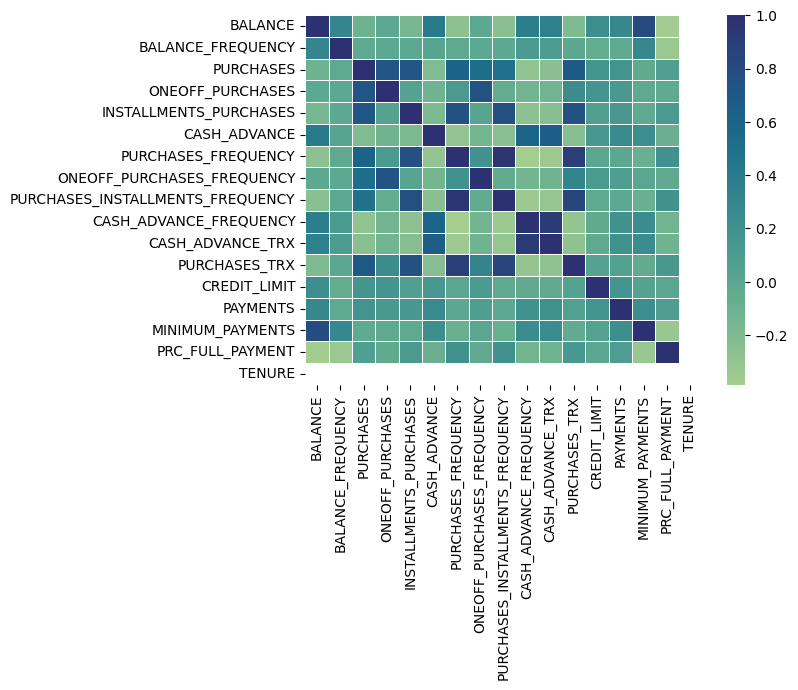

In [21]:
sns.heatmap(credit_data.corr(), cmap='crest', linewidths=0.7)

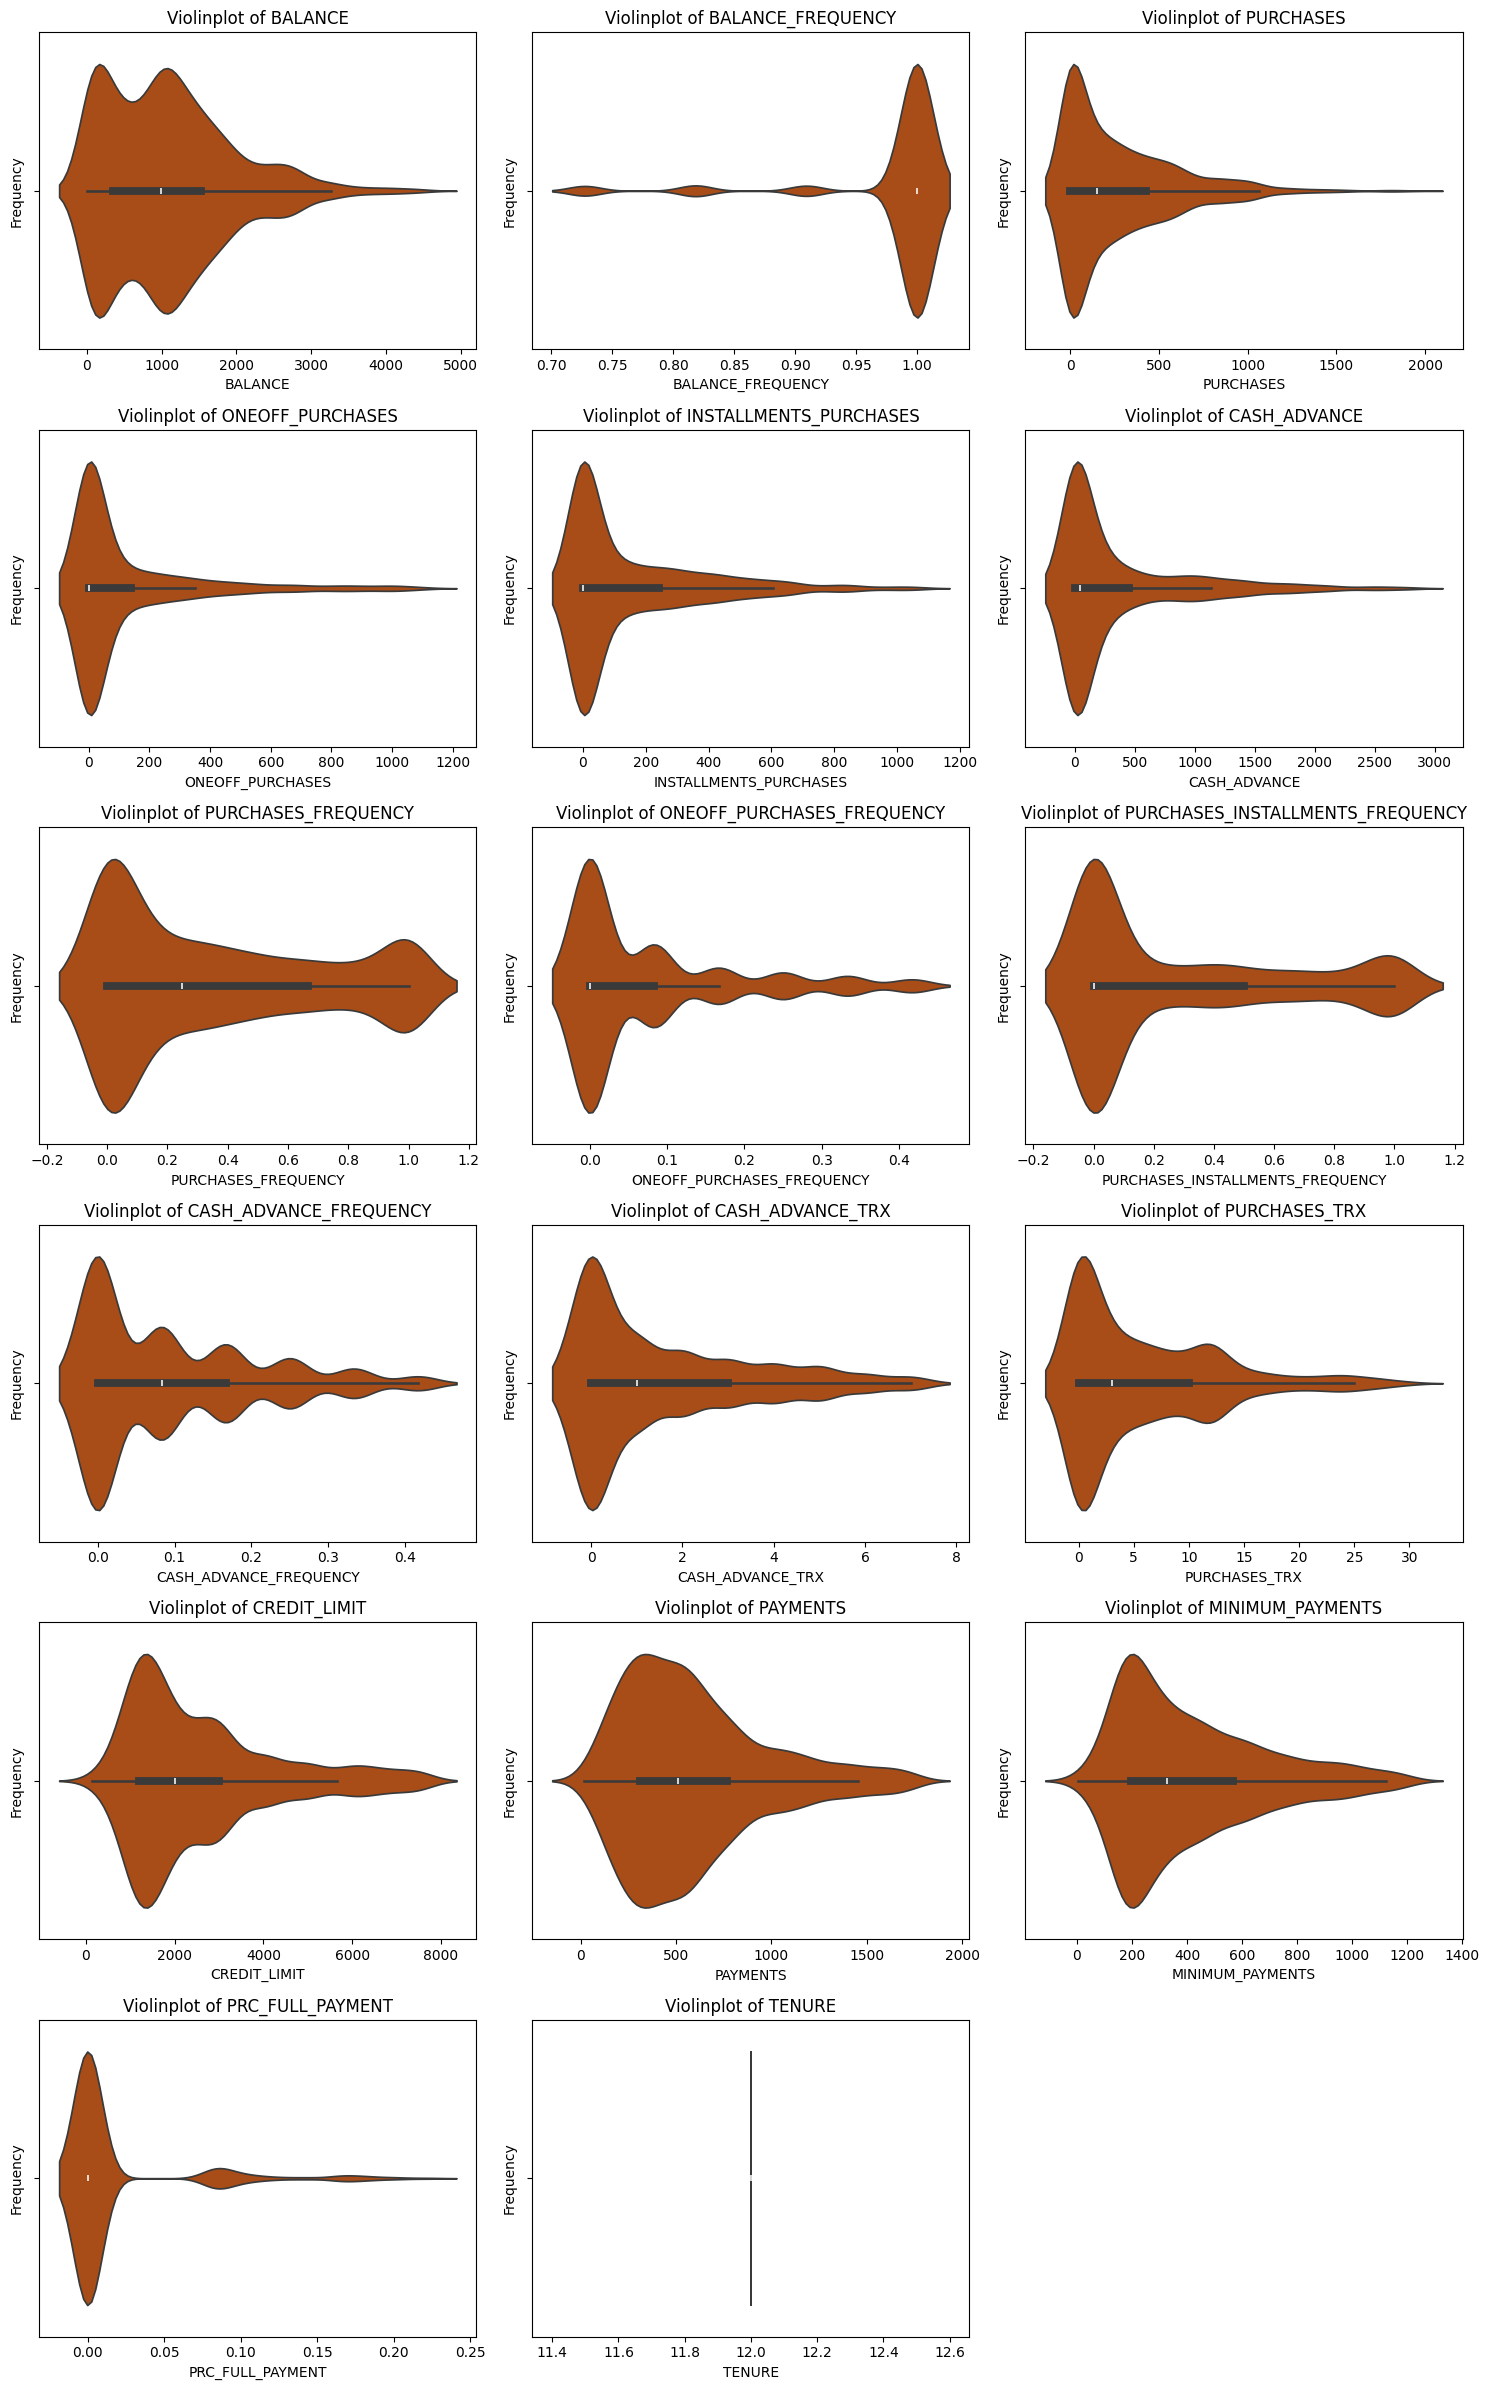

In [22]:
num_columns = credit_data.select_dtypes(include='number').columns

n_cols = 3 
n_rows = (len(num_columns) + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

axes = axes.flatten()

for i, column in enumerate(num_columns):
    sns.violinplot(data=credit_data, x=column,ax=axes[i], color='#C14600')
    axes[i].set_title(f'Violinplot of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [23]:
credit_data.isna().sum().sum()

0

In [24]:
pca = PCA(n_components = 0.90)
credit_pca_data = pca.fit_transform(credit_data)

In [25]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

In [26]:
cumulative_variance

array([0.6827212 , 0.86638292, 0.92492801])

In [27]:
credit_pca_data = pd.DataFrame(data=credit_pca_data, columns=["PC1", "PC2", "PC3"])

In [28]:
min_max_scaler = MinMaxScaler()
credit_pca_data = pd.DataFrame(data=min_max_scaler.fit_transform(credit_pca_data), 
                               columns=["PC1", "PC2", "PC3"])

credit_pca_data.head(2)

,PC1,PC2,PC3
0,0.103706,0.209809,0.481651
1,0.145781,0.352064,0.431397


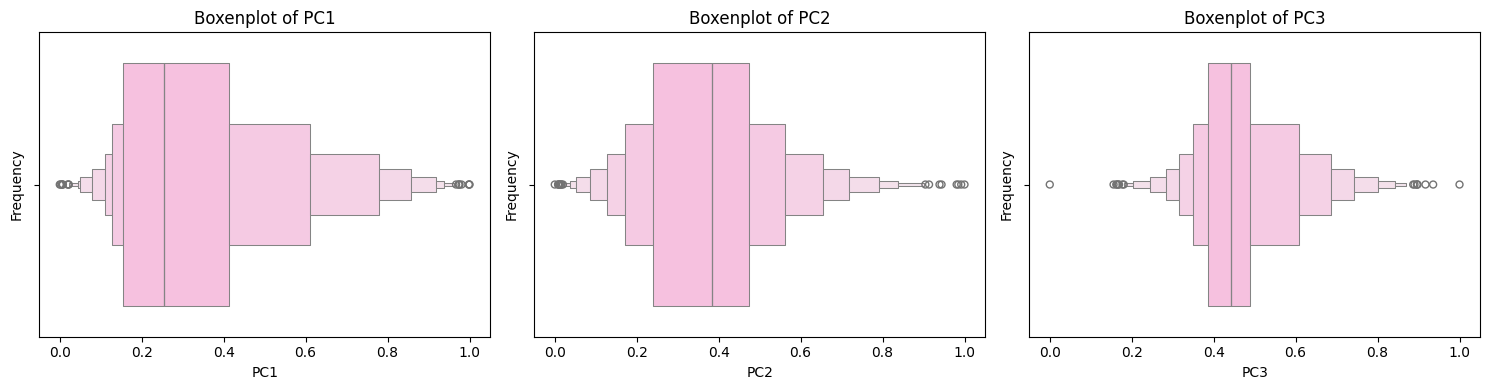

In [29]:
num_columns = credit_pca_data.select_dtypes(include='number').columns

n_cols = 3 
n_rows = (len(num_columns) + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

axes = axes.flatten()

for i, column in enumerate(num_columns):
    sns.boxenplot(data=credit_pca_data, x=column,ax=axes[i], color='#FFB8E0')
    axes[i].set_title(f'Boxenplot of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [30]:
cluster_range = range(2, 10)
inertia = []
silhouette_score_vals = []

for k in cluster_range:
    k_means_model = KMeans(n_clusters=k)
    cluster_labels = k_means_model.fit_predict(credit_pca_data)
    
    inertia.append(k_means_model.inertia_)
    silhouette_score_vals.append(silhouette_score(credit_pca_data, cluster_labels))
print(inertia)
print(silhouette_score_vals)

[110.86526452664822, 79.074764293694, 66.61075867283847, 55.65943496073034, 45.58767314901787, 40.5329192374654, 37.88656647487392, 31.513500219115766]
[0.46999283157848815, 0.44584092271300646, 0.4128089847260977, 0.34582646524644556, 0.34857430950326707, 0.35948218372632507, 0.31103788179351044, 0.34836800848209404]


In [31]:
kneedle = KneeLocator(cluster_range, inertia, curve='convex', direction='decreasing')
optimum_clusters = kneedle.elbow
print("Optimum number of cluster is", optimum_clusters)

Optimum number of cluster is 4


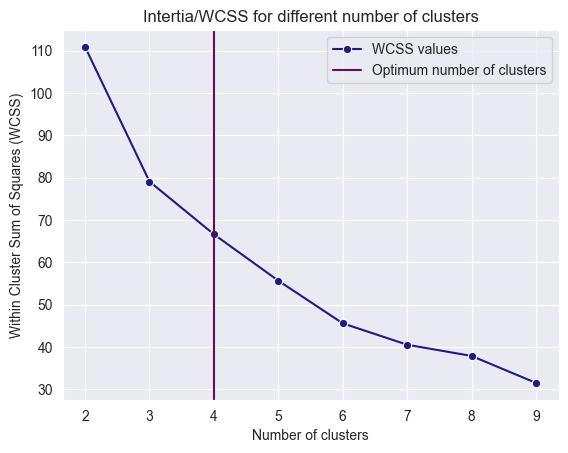

In [32]:
sns.set_style('darkgrid')
sns.lineplot(y=inertia, x=cluster_range, marker='o', color='#211C84', label="WCSS values")
plt.xticks(cluster_range)
plt.axvline(x=optimum_clusters, color='#640D5F', label='Optimum number of clusters')
plt.xlabel("Number of clusters")
plt.ylabel("Within Cluster Sum of Squares (WCSS)")
plt.title("Intertia/WCSS for different number of clusters")
plt.legend()
plt.show()

In [33]:
k_means_pca_data = KMeans(n_clusters=optimum_clusters, init='k-means++')
credit_pca_data['Cluster'] = k_means_pca_data.fit_predict(credit_pca_data)
silhouette_score(credit_pca_data, credit_pca_data["Cluster"])

0.7973313174766785

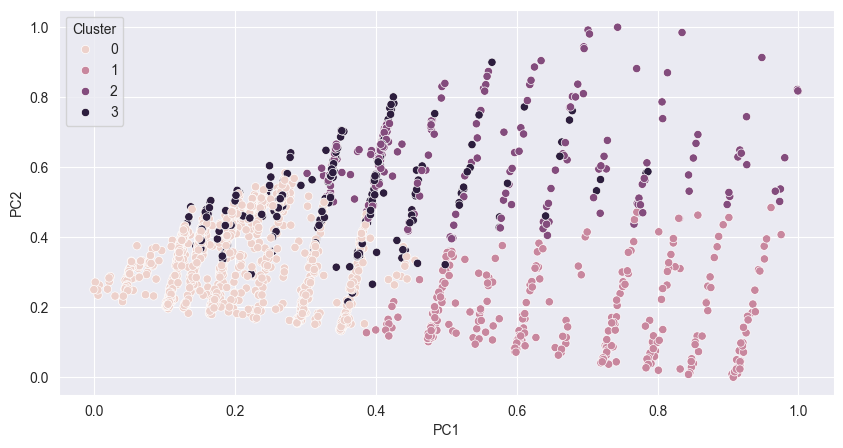

In [34]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=credit_pca_data, x='PC1', y='PC2', hue='Cluster')
plt.show()

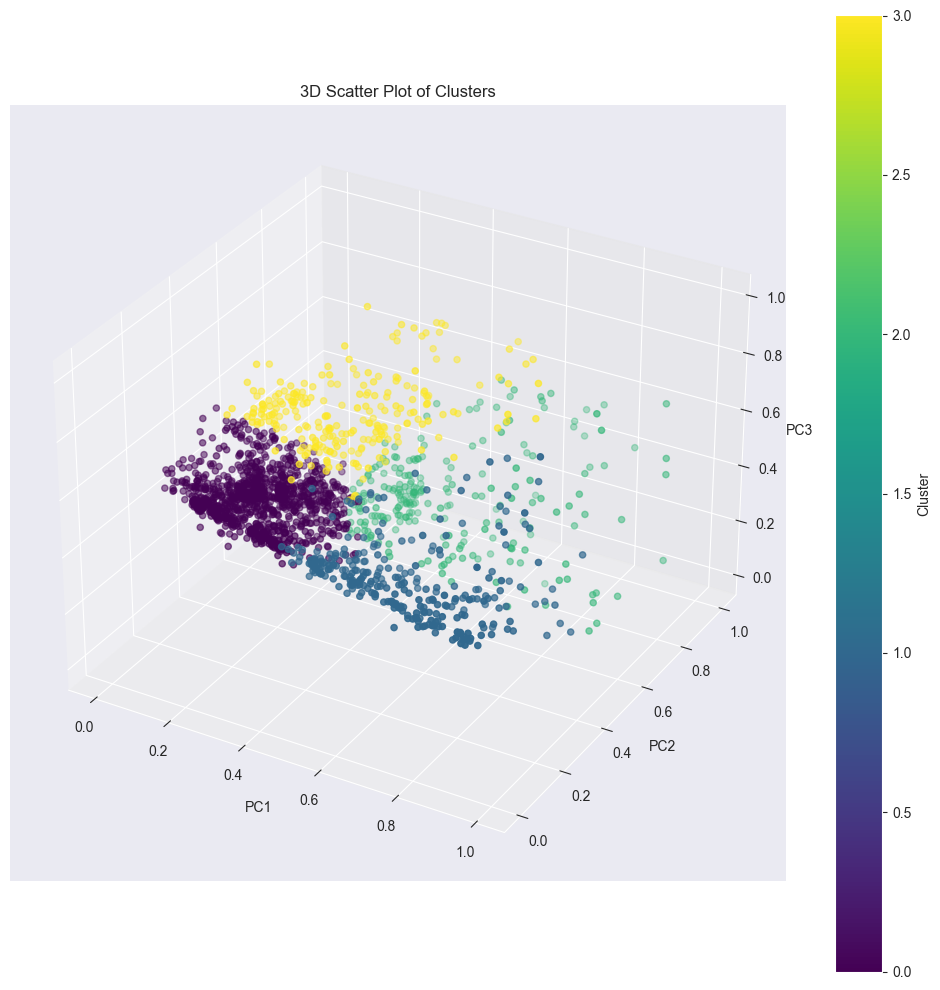

In [35]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(credit_pca_data['PC1'], credit_pca_data['PC2'], credit_pca_data['PC3'], 
                     c=credit_pca_data['Cluster'], 
                     cmap='viridis')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
fig.colorbar(scatter, label='Cluster')
ax.set_title('3D Scatter Plot of Clusters')
plt.tight_layout()
plt.show()

In [36]:
submission_dataframe = pd.DataFrame({
    'Index': credit_pca_data.index,
    'Cluster': credit_pca_data['Cluster']
}).sort_values(by="Index")
display(submission_dataframe.head(2))
display(submission_dataframe.tail(2))

,Index,Cluster
0,0,0
1,1,0


,Index,Cluster
1976,1976,0
1977,1977,0


In [ ]:
submission_dataframe.to_csv("../d. Output Files/Credit Card Clustering/Credit Card Clustering.csv", index=False)